In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
folder_path = "C:/Users/user/Downloads/Train_200/Train_200"
target_categories = ['fresh_strawberry', 'fresh_pomegranate', 'stale_strawberry', 'stale_cucumber', 'stale_pomegranate', 'fresh_cucumber','fresh_peach',
                     'fresh_apple','fresh_banana','fresh_orange','fresh_tomato','stale_apple','stale_banana','stale_orange','stale_tomato','stale_peach']

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

def train_val_datasets():
    """Creates training and validation datasets with an 80-20 split from the main directory.

    Returns:
        (tf.data.Dataset, tf.data.Dataset): training and validation datasets
    """

    # Define the directory where the dataset is stored
    DATASET = folder_path

    # Apply validation_split on the main dataset and split the data into training and validation sets
    training_dataset = image_dataset_from_directory(
        directory=DATASET,
        batch_size=32,
        image_size=(150, 150),
        shuffle=True,
        seed=7,
        validation_split=0.2,  # Reserve 20% for validation
        subset="training",  # Training data
    )

    validation_dataset = image_dataset_from_directory(
        directory=DATASET,
        batch_size=32,
        image_size=(150, 150),
        shuffle=True,
        seed=7,
        validation_split=0.2,  # Reserve 20% for validation
        subset="validation",  # Validation data
    )

    return training_dataset, validation_dataset

# Get the datasets
training_dataset, validation_dataset = train_val_datasets()

Found 3200 files belonging to 16 classes.
Using 2560 files for training.
Found 3200 files belonging to 16 classes.
Using 640 files for validation.


In [4]:
def create_pre_trained_model():
    """Creates the pretrained inception V3 model

    Returns:
        tf.keras.Model: pre-trained model
    """

    pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
        include_top=False,
        input_shape=(150,150,3),
        weights='imagenet'
    )

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

In [5]:
pre_trained_model = create_pre_trained_model()

In [6]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.95:
            self.model.stop_training = True
            print("\nReached 85% accuracy so cancelling training!")

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik yang dimonitor
    patience=3,          # Beri 3 epoch kesempatan untuk membaik
    restore_best_weights=True  # Kembalikan model ke bobot terbaik
)

In [7]:
def output_of_last_layer(pre_trained_model):
    """Fetches the output of the last desired layer of the pre-trained model

    Args:
        pre_trained_model (tf.keras.Model): pre-trained model

    Returns:
        tf.keras.KerasTensor: last desired layer of pretrained model
    """

    last_desired_layer = pre_trained_model.get_layer('mixed10')
    last_output = last_desired_layer.output

    print('last layer output shape: ', last_output.shape)

    return last_output

In [8]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 3, 3, 2048)


In [9]:
def create_final_model(pre_trained_model, last_output):
    """Creates final model by adding layers on top of the pretrained model.

    Args:
        pre_trained_model (tf.keras.Model): pre-trained inceptionV3 model
        last_output (tf.keras.KerasTensor): last layer of the pretrained model

    Returns:
        Tensorflow model: final model
    """

    # Flatten the output layer of the pretrained model to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(288, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(16, activation='softmax')(x)

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
model = create_final_model(pre_trained_model, last_output)

In [11]:
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, depth=16)
    return image, label

# Apply the preprocessing to all datasets
training_dataset = training_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

In [13]:
with tf.device('/GPU:0'):
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        epochs = 5,
        verbose = 2,
        #callbacks = [EarlyStoppingCallback()],
)

Epoch 1/5
80/80 - 83s - 1s/step - accuracy: 0.8438 - loss: 0.5000 - val_accuracy: 0.8687 - val_loss: 0.4225
Epoch 2/5
80/80 - 85s - 1s/step - accuracy: 0.9039 - loss: 0.2985 - val_accuracy: 0.8516 - val_loss: 0.4544
Epoch 3/5
80/80 - 86s - 1s/step - accuracy: 0.9070 - loss: 0.2705 - val_accuracy: 0.8656 - val_loss: 0.4308
Epoch 4/5
80/80 - 82s - 1s/step - accuracy: 0.9281 - loss: 0.2066 - val_accuracy: 0.8641 - val_loss: 0.4845
Epoch 5/5
80/80 - 89s - 1s/step - accuracy: 0.9586 - loss: 0.1275 - val_accuracy: 0.8844 - val_loss: 0.3947


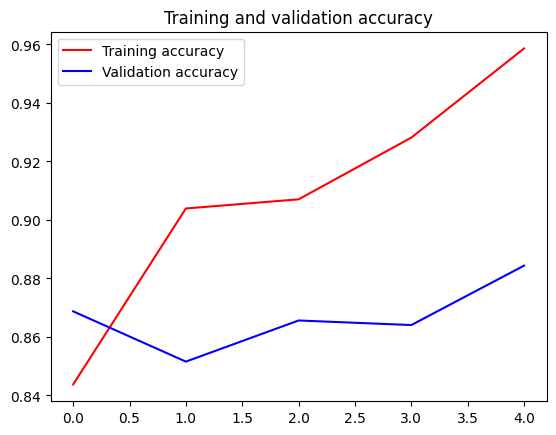

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [17]:
pre_trained_model.trainable = True
for layer in pre_trained_model.layers[:-30]:  # Membekukan sebagian besar layer, hanya membuka layer terakhir
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine_tune = model.fit(training_dataset,
                              validation_data=validation_dataset,
                              epochs=10,
                              callbacks=[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
                              ])

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9608 - loss: 0.1106 - val_accuracy: 0.8953 - val_loss: 0.3696
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 79s 993ms/step - accuracy: 0.9699 - loss: 0.0848 - val_accuracy: 0.8969 - val_loss: 0.3643
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 933ms/step - accuracy: 0.9688 - loss: 0.0722 - val_accuracy: 0.8953 - val_loss: 0.3580
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 77s 962ms/step - accuracy: 0.9802 - loss: 0.0693 - val_accuracy: 0.9000 - val_loss: 0.3527
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9815 - loss: 0.0558 - val_accuracy: 0.8984 - val_loss: 0.3528
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 940ms/step - accuracy: 0.9836 - loss: 0.0540 - val_accuracy: 0.9000 - val_loss: 0.3517
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9775 - loss: 0.0595 - val_accuracy: 0.9016 - val_loss: 0.3500
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9809 - loss: 0.0484 - val_accuracy: 0.90

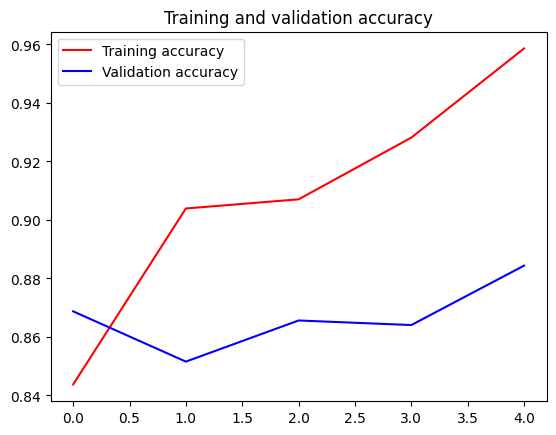

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

Found 3200 files belonging to 16 classes.
Using 640 files for validation.
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 376ms/step


<Figure size 1200x1200 with 0 Axes>

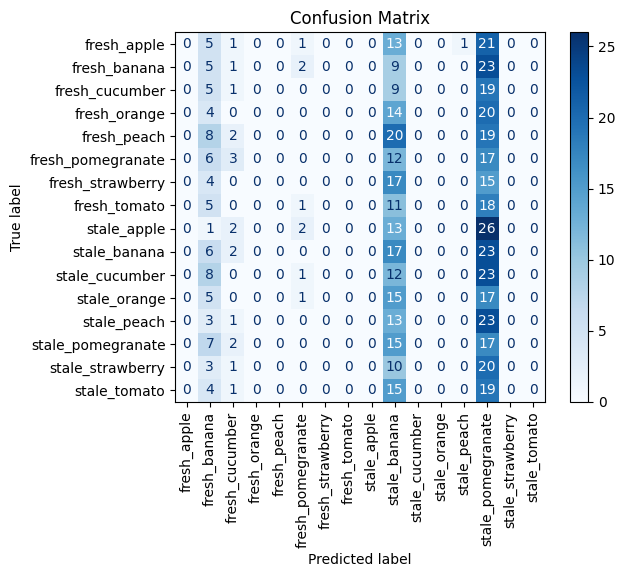

Classification Report:
                   precision    recall  f1-score   support

      fresh_apple       0.00      0.00      0.00        42
     fresh_banana       0.06      0.12      0.08        40
   fresh_cucumber       0.06      0.03      0.04        34
     fresh_orange       0.00      0.00      0.00        38
      fresh_peach       0.00      0.00      0.00        49
fresh_pomegranate       0.00      0.00      0.00        38
 fresh_strawberry       0.00      0.00      0.00        36
     fresh_tomato       0.00      0.00      0.00        35
      stale_apple       0.00      0.00      0.00        44
     stale_banana       0.08      0.35      0.13        48
   stale_cucumber       0.00      0.00      0.00        44
     stale_orange       0.00      0.00      0.00        38
      stale_peach       0.00      0.00      0.00        40
stale_pomegranate       0.05      0.41      0.09        41
 stale_strawberry       0.00      0.00      0.00        34
     stale_tomato       0.00    

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Mendapatkan prediksi dan label sebenarnya dari data validasi
validation_dataset = image_dataset_from_directory(
    directory=folder_path,
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=7,
    validation_split=0.2,  # Reserve 20% for validation
    subset="validation",  # Validation data
)

# Menggabungkan label sebenarnya dari setiap batch
true_classes = np.concatenate([y for x, y in validation_dataset], axis=0)

# Mendapatkan prediksi dari model
predicted_classes = np.argmax(model.predict(validation_dataset), axis=1)

# Mendapatkan nama kelas
class_labels = validation_dataset.class_names  # Nama kelas dari dataset

# Membuat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Menampilkan confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(12, 12))
cmd.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Menampilkan classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi: stale_banana (Probabilitas: 1.00)


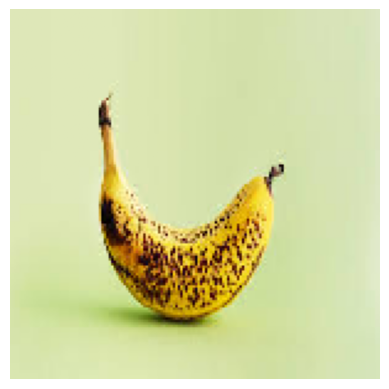

In [37]:
#Memprediksi model menggunakan data baru
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from matplotlib.pyplot import imshow
img_path = "C:/Users/user/Downloads/fruit_dataset/Test/image_1.jpg"
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img(img_path, target_size=(150,150))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

answer = model.predict(img)

# Menentukan kelas dengan threshold
predicted_class = np.argmax(answer[0])  # Mendapatkan indeks kelas dengan probabilitas tertinggi
predicted_label = idc[predicted_class]  # Mendapatkan label kelas

print(f"Prediksi: {predicted_label} (Probabilitas: {answer[0][predicted_class]:.2f})")